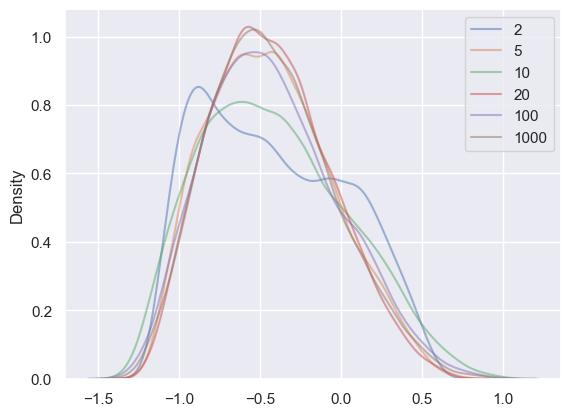

In [72]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

N = 10000
alpha = np.random.randn()
beta = np.random.randn(1000)
for p in [2,5,10,20,100,1000]:
    X = np.random.rand(N*p).reshape((N,p))
    # eta = X.dot(beta[:p]) + alpha
    eta = 2*(X-0.5).dot(beta[:p])/np.sqrt(p) + alpha
    k = 4
    z = 3 * stats.logistic.cdf(eta) - 1.5
    sns.kdeplot(z, alpha=0.5, label=p)
plt.legend();

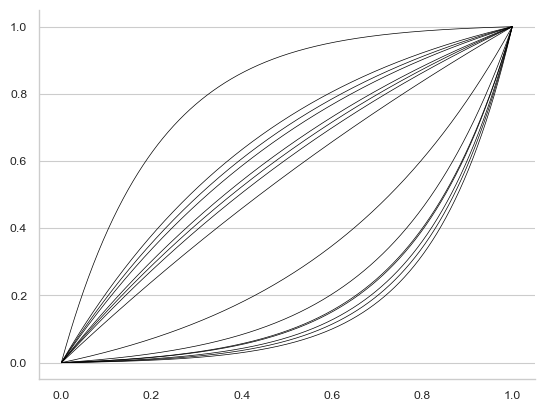

In [198]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper")

np.random.seed(41)

N = 10000
p = 10
alpha = np.random.randn()
beta = np.random.randn(p)

t = np.linspace(0,1,1000)
def m(x):
    eta = 2*(x-0.5).dot(beta)/np.sqrt(p) + alpha
    k = 4
    a = 3 * stats.logistic.cdf(eta) - 1.5
    gam_t = (np.exp(k*(a * t)) - 1) / (np.exp(k*a) - 1)
    # return (1 - np.power(gam_t - 0.5, 2)) * np.sin(np.pi * 9 * gam_t)
    return gam_t

for i in range(15):
    sns.lineplot(x=t, y=m(np.random.randn(p)), color='black', alpha=1, linewidth=0.5)

plt.gca().spines[['right', 'top']].set_visible(False)
plt.grid(axis='x')
plt.savefig('sample_phase.pdf')

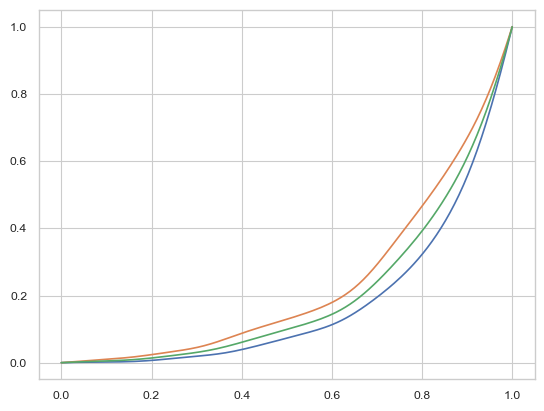

In [250]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 
import numpy as np
from scipy import stats
from pyfrechet.metric_spaces import *
from pyfrechet.metric_spaces import FisherRaoPhase
from benchmark import bench
import skfda
from skfda.misc.operators import SRSF
from skfda.misc import inner_product




N = 2
p = 10
alpha = np.random.randn()
beta = np.random.randn(p)

x, y, mx = gen_data(N,p,alpha,beta)

fig = skfda.FDataGrid(y.data, y.M.grid).plot();
skfda.FDataGrid(y.frechet_mean(), y.M.grid).plot(fig=fig);


[1.00000606]
[1.00000537]


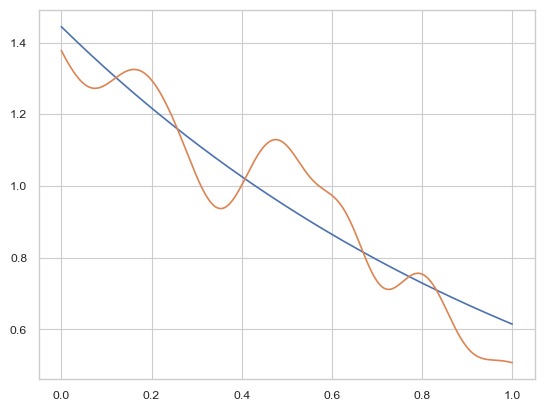

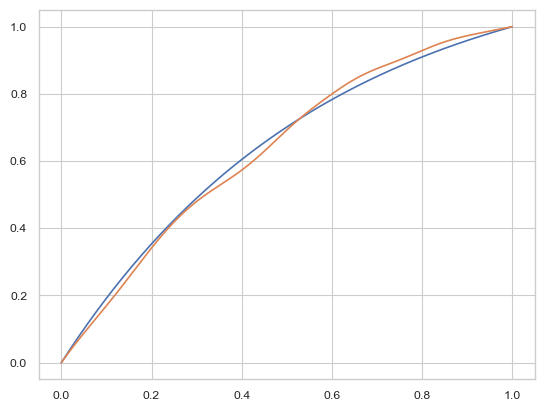

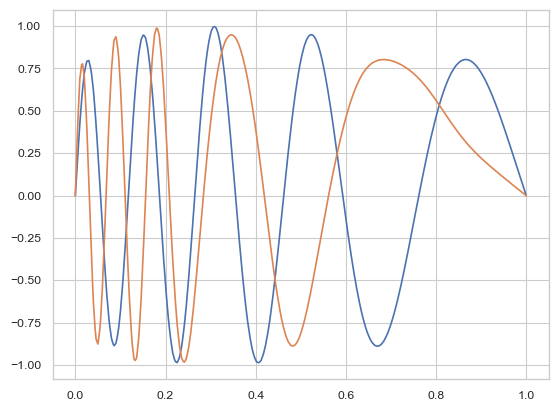

In [229]:
import skfda
from skfda.misc.operators import SRSF
from skfda.misc import inner_product

# np.random.seed(5)
template = skfda.FDataGrid((1 - np.power(t - 0.5, 2)) * np.sin(np.pi * 9 * t), t)

mx = m(np.random.randn(p))

eps = 0.1
t = np.linspace(0,1,200)

x = np.random.randn(p)
eta = 2*(x-0.5).dot(beta)/np.sqrt(p) + alpha
k = 4
a = 3 * stats.logistic.cdf(eta) - 1.5
gam_t = (np.exp(k*(a * t)) - 1) / (np.exp(k*a) - 1)
mx = (1 - np.power(gam_t - 0.5, 2)) * np.sin(np.pi * 9 * gam_t)

y = skfda.FDataGrid(mx, t)
gam_y = skfda.FDataGrid(gam_t, t)


srsf = SRSF()
psi = srsf.fit_transform(gam_y)

v = skfda.FDataGrid(gp(t, kernel), t)
vx = v - inner_product(psi, v) * psi
nvx = skfda.misc.metrics.LpNorm(2)(vx)

psi_pv = np.cos(eps * nvx) * psi + np.sin(eps * nvx) * vx / nvx
gam_pv = srsf.inverse_transform(psi_pv)

y_pv = y.compose(gam_pv)

print(skfda.misc.metrics.LpNorm(2)(psi))
print(skfda.misc.metrics.LpNorm(2)(psi_pv))

# template.plot();
# y.plot();
# plt.plot(t, gam_t);
# y.plot()
# q.plot()

fig=psi.plot()
psi_pv.plot(fig=fig)

fig=gam_y.plot()
gam_pv.plot(fig=fig);

fig=y.plot()
y_pv.plot(fig=fig);

# qpv.plot();

# skfda.misc.metrics.LpNorm(2)(q)

In [1]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 
import numpy as np
from scipy import stats
from pyfrechet.metric_spaces import *
from pyfrechet.metric_spaces import FisherRaoPhase
from benchmark import bench
import skfda
from skfda.misc.operators import SRSF
from skfda.misc import inner_product

OUT_FILE = 'result_phase_cross_est_new_dgp_2.json'

def gen_data(N, p, alpha, beta):
    M = FisherRaoPhase(np.linspace(0,1,100))
    t = M.grid

    def m(x):
        eta = 2*(x-0.5).dot(beta)/np.sqrt(p) + alpha
        k = 4
        a = 3 * stats.logistic.cdf(eta) - 1.5
        return (np.exp(k*(a * t)) - 1) / (np.exp(k*a) - 1)
    
    def add_noise(gam, eps = 0.1):
        k = lambda x1, x2: np.exp(-100 * np.subtract.outer(x1, x2)**2)
        gp = lambda t: np.random.multivariate_normal(mean=np.zeros(len(t)), cov=k(t,t))
        
        # map to psi = srsf of gamma which lies on the sphere
        srsf = SRSF()
        gam = skfda.FDataGrid(gam, t)
        psi = srsf.fit_transform(gam)

        # sample a random tangent vector
        v = skfda.FDataGrid(gp(t), t)
        vx = v - inner_product(psi, v) * psi
        nvx = skfda.misc.metrics.LpNorm(2)(vx)

        # apply it to psi and transform back to gamma space
        psi_pv = np.cos(eps * nvx) * psi + np.sin(eps * nvx) * vx / nvx
        return srsf.inverse_transform(psi_pv).data_matrix[0,...,0]

    x = np.random.rand(N*p).reshape((N,p))
    mx = np.array([ m(x[i,:]) for i in range(N)])
    y = np.array([ add_noise(mx[i,:]) for i in range(N)])
    return x, MetricData(M, y), MetricData(M, mx)

bench(
    gen_data,
    OUT_FILE,
    ps=[2, 5, 10, 20],
    Ns=[50,100,200,400],
    replicas=5
)

INFO: Using numpy backend
INFO: NumExpr defaulting to 8 threads.


[2023-06-13 17:22:26.611399] Progress: N=50	p=2	i=0
[2023-06-13 17:22:28.026984] Distances for cart_2means
[2023-06-13 17:22:28.027103] dt = 0
[2023-06-13 17:22:28.027123] Fitting for cart_2means
[2023-06-13 17:22:29.703344] dt = 1.676361322402954
[2023-06-13 17:22:29.703416] MSE for cart_2means
[2023-06-13 17:22:32.769932] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    2.1s finished


[2023-06-13 17:22:34.872149] dt = 2.102141857147217
[2023-06-13 17:22:34.872204] Fitting for medoid_greedy
[2023-06-13 17:22:34.878606] dt = 0.006533145904541016
[2023-06-13 17:22:34.878616] MSE for medoid_greedy
[2023-06-13 17:22:37.106983] Progress: N=50	p=2	i=1
[2023-06-13 17:22:37.694923] Distances for cart_2means
[2023-06-13 17:22:37.695023] dt = 0
[2023-06-13 17:22:37.695042] Fitting for cart_2means
[2023-06-13 17:22:39.228917] dt = 1.5339939594268799
[2023-06-13 17:22:39.228995] MSE for cart_2means
[2023-06-13 17:22:42.284744] Distances for medoid_greedy
[2023-06-13 17:22:42.331654] dt = 0.046838998794555664
[2023-06-13 17:22:42.331670] Fitting for medoid_greedy
[2023-06-13 17:22:42.337655] dt = 0.006072282791137695
[2023-06-13 17:22:42.337662] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:22:44.327483] Progress: N=50	p=2	i=2
[2023-06-13 17:22:45.012329] Distances for cart_2means
[2023-06-13 17:22:45.012433] dt = 0
[2023-06-13 17:22:45.012452] Fitting for cart_2means
[2023-06-13 17:22:46.068054] dt = 1.05572509765625
[2023-06-13 17:22:46.068131] MSE for cart_2means
[2023-06-13 17:22:48.179449] Distances for medoid_greedy
[2023-06-13 17:22:48.226160] dt = 0.04664015769958496
[2023-06-13 17:22:48.226177] Fitting for medoid_greedy
[2023-06-13 17:22:48.232585] dt = 0.00649571418762207
[2023-06-13 17:22:48.232594] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:22:49.800100] Progress: N=50	p=2	i=3
[2023-06-13 17:22:52.159752] Distances for cart_2means
[2023-06-13 17:22:52.159918] dt = 0
[2023-06-13 17:22:52.159942] Fitting for cart_2means
[2023-06-13 17:22:53.850994] dt = 1.6912422180175781
[2023-06-13 17:22:53.851080] MSE for cart_2means
[2023-06-13 17:22:56.222529] Distances for medoid_greedy
[2023-06-13 17:22:56.262984] dt = 0.04038500785827637
[2023-06-13 17:22:56.262998] Fitting for medoid_greedy
[2023-06-13 17:22:56.268929] dt = 0.0060138702392578125
[2023-06-13 17:22:56.268949] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:22:59.385861] Progress: N=50	p=2	i=4
[2023-06-13 17:23:00.252407] Distances for cart_2means
[2023-06-13 17:23:00.252481] dt = 0
[2023-06-13 17:23:00.252489] Fitting for cart_2means
[2023-06-13 17:23:01.751230] dt = 1.4988226890563965
[2023-06-13 17:23:01.751313] MSE for cart_2means
[2023-06-13 17:23:05.043646] Distances for medoid_greedy
[2023-06-13 17:23:05.086693] dt = 0.04297900199890137
[2023-06-13 17:23:05.086706] Fitting for medoid_greedy
[2023-06-13 17:23:05.092923] dt = 0.006299018859863281
[2023-06-13 17:23:05.092931] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:23:06.773654] Progress: N=50	p=5	i=0
[2023-06-13 17:23:07.488817] Distances for cart_2means
[2023-06-13 17:23:07.488942] dt = 0
[2023-06-13 17:23:07.488965] Fitting for cart_2means
[2023-06-13 17:23:11.864947] dt = 4.376129865646362
[2023-06-13 17:23:11.865026] MSE for cart_2means
[2023-06-13 17:23:14.520879] Distances for medoid_greedy
[2023-06-13 17:23:14.559135] dt = 0.038179874420166016
[2023-06-13 17:23:14.559148] Fitting for medoid_greedy
[2023-06-13 17:23:14.573354] dt = 0.014295101165771484
[2023-06-13 17:23:14.573363] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  37 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:23:17.330142] Progress: N=50	p=5	i=1
[2023-06-13 17:23:18.026294] Distances for cart_2means
[2023-06-13 17:23:18.026406] dt = 0
[2023-06-13 17:23:18.026430] Fitting for cart_2means
[2023-06-13 17:23:22.038027] dt = 4.011733055114746
[2023-06-13 17:23:22.038107] MSE for cart_2means
[2023-06-13 17:23:25.107934] Distances for medoid_greedy
[2023-06-13 17:23:25.164843] dt = 0.05683183670043945
[2023-06-13 17:23:25.164859] Fitting for medoid_greedy
[2023-06-13 17:23:25.179555] dt = 0.014789104461669922
[2023-06-13 17:23:25.179577] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.1s finished


[2023-06-13 17:23:28.543648] Progress: N=50	p=5	i=2
[2023-06-13 17:23:30.076695] Distances for cart_2means
[2023-06-13 17:23:30.076802] dt = 0
[2023-06-13 17:23:30.076828] Fitting for cart_2means
[2023-06-13 17:23:35.057154] dt = 4.980458974838257
[2023-06-13 17:23:35.057236] MSE for cart_2means
[2023-06-13 17:23:37.708894] Distances for medoid_greedy
[2023-06-13 17:23:37.753640] dt = 0.044615983963012695
[2023-06-13 17:23:37.753655] Fitting for medoid_greedy
[2023-06-13 17:23:37.768481] dt = 0.01497507095336914
[2023-06-13 17:23:37.768489] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:23:40.150636] Progress: N=50	p=5	i=3
[2023-06-13 17:23:40.944672] Distances for cart_2means
[2023-06-13 17:23:40.944868] dt = 0
[2023-06-13 17:23:40.944892] Fitting for cart_2means
[2023-06-13 17:23:45.906977] dt = 4.962305068969727
[2023-06-13 17:23:45.907057] MSE for cart_2means
[2023-06-13 17:23:49.325903] Distances for medoid_greedy
[2023-06-13 17:23:49.370456] dt = 0.044480085372924805
[2023-06-13 17:23:49.370475] Fitting for medoid_greedy
[2023-06-13 17:23:49.385761] dt = 0.015376806259155273
[2023-06-13 17:23:49.385787] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:23:51.864542] Progress: N=50	p=5	i=4
[2023-06-13 17:23:52.782307] Distances for cart_2means
[2023-06-13 17:23:52.782668] dt = 0
[2023-06-13 17:23:52.782802] Fitting for cart_2means
[2023-06-13 17:23:57.559232] dt = 4.776925086975098
[2023-06-13 17:23:57.559305] MSE for cart_2means
[2023-06-13 17:24:00.300172] Distances for medoid_greedy
[2023-06-13 17:24:00.344265] dt = 0.04402303695678711
[2023-06-13 17:24:00.344281] Fitting for medoid_greedy
[2023-06-13 17:24:00.361625] dt = 0.01743006706237793
[2023-06-13 17:24:00.361635] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:24:03.060098] Progress: N=50	p=10	i=0
[2023-06-13 17:24:03.833776] Distances for cart_2means
[2023-06-13 17:24:03.836795] dt = 0
[2023-06-13 17:24:03.836820] Fitting for cart_2means
[2023-06-13 17:24:12.479822] dt = 8.646045923233032
[2023-06-13 17:24:12.479901] MSE for cart_2means
[2023-06-13 17:24:15.408625] Distances for medoid_greedy
[2023-06-13 17:24:15.449232] dt = 0.040537118911743164
[2023-06-13 17:24:15.449249] Fitting for medoid_greedy
[2023-06-13 17:24:15.483417] dt = 0.03425478935241699
[2023-06-13 17:24:15.483429] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:24:18.406822] Progress: N=50	p=10	i=1
[2023-06-13 17:24:19.089709] Distances for cart_2means
[2023-06-13 17:24:19.090251] dt = 0
[2023-06-13 17:24:19.090274] Fitting for cart_2means
[2023-06-13 17:24:28.422746] dt = 9.33303689956665
[2023-06-13 17:24:28.422832] MSE for cart_2means
[2023-06-13 17:24:31.352904] Distances for medoid_greedy
[2023-06-13 17:24:31.398854] dt = 0.045884132385253906
[2023-06-13 17:24:31.398876] Fitting for medoid_greedy
[2023-06-13 17:24:31.431683] dt = 0.03289389610290527
[2023-06-13 17:24:31.431704] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  37 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:24:34.063916] Progress: N=50	p=10	i=2
[2023-06-13 17:24:35.370911] Distances for cart_2means
[2023-06-13 17:24:35.371027] dt = 0
[2023-06-13 17:24:35.371052] Fitting for cart_2means
[2023-06-13 17:24:46.156682] dt = 10.785771131515503
[2023-06-13 17:24:46.156761] MSE for cart_2means
[2023-06-13 17:24:49.746216] Distances for medoid_greedy
[2023-06-13 17:24:49.795282] dt = 0.04898786544799805
[2023-06-13 17:24:49.795299] Fitting for medoid_greedy
[2023-06-13 17:24:49.826088] dt = 0.030884265899658203
[2023-06-13 17:24:49.826107] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:24:53.295005] Progress: N=50	p=10	i=3
[2023-06-13 17:24:53.961783] Distances for cart_2means
[2023-06-13 17:24:53.961883] dt = 0
[2023-06-13 17:24:53.961902] Fitting for cart_2means
[2023-06-13 17:25:02.671068] dt = 8.709284782409668
[2023-06-13 17:25:02.671156] MSE for cart_2means
[2023-06-13 17:25:04.912885] Distances for medoid_greedy
[2023-06-13 17:25:04.953207] dt = 0.040251970291137695
[2023-06-13 17:25:04.953223] Fitting for medoid_greedy
[2023-06-13 17:25:04.983108] dt = 0.029972076416015625
[2023-06-13 17:25:04.983119] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:25:07.574705] Progress: N=50	p=10	i=4
[2023-06-13 17:25:08.366174] Distances for cart_2means
[2023-06-13 17:25:08.366289] dt = 0
[2023-06-13 17:25:08.366311] Fitting for cart_2means
[2023-06-13 17:25:18.846845] dt = 10.480669736862183
[2023-06-13 17:25:18.846924] MSE for cart_2means
[2023-06-13 17:25:22.336349] Distances for medoid_greedy
[2023-06-13 17:25:22.378077] dt = 0.04166293144226074
[2023-06-13 17:25:22.378104] Fitting for medoid_greedy
[2023-06-13 17:25:22.409826] dt = 0.031815290451049805
[2023-06-13 17:25:22.409836] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:25:25.199647] Progress: N=50	p=20	i=0
[2023-06-13 17:25:26.110347] Distances for cart_2means
[2023-06-13 17:25:26.111062] dt = 0
[2023-06-13 17:25:26.111083] Fitting for cart_2means
[2023-06-13 17:25:46.155087] dt = 20.044739961624146
[2023-06-13 17:25:46.155172] MSE for cart_2means
[2023-06-13 17:25:49.359273] Distances for medoid_greedy
[2023-06-13 17:25:49.401312] dt = 0.04196977615356445
[2023-06-13 17:25:49.401330] Fitting for medoid_greedy
[2023-06-13 17:25:49.462204] dt = 0.060961008071899414
[2023-06-13 17:25:49.462227] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  37 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:25:52.214417] Progress: N=50	p=20	i=1
[2023-06-13 17:25:53.074419] Distances for cart_2means
[2023-06-13 17:25:53.074535] dt = 0
[2023-06-13 17:25:53.074558] Fitting for cart_2means
[2023-06-13 17:26:13.263169] dt = 20.18874716758728
[2023-06-13 17:26:13.263301] MSE for cart_2means
[2023-06-13 17:26:16.074664] Distances for medoid_greedy
[2023-06-13 17:26:16.120450] dt = 0.045712947845458984
[2023-06-13 17:26:16.120465] Fitting for medoid_greedy
[2023-06-13 17:26:16.206638] dt = 0.08626008033752441
[2023-06-13 17:26:16.206659] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:26:18.876780] Progress: N=50	p=20	i=2
[2023-06-13 17:26:19.619628] Distances for cart_2means
[2023-06-13 17:26:19.620842] dt = 0
[2023-06-13 17:26:19.620865] Fitting for cart_2means
[2023-06-13 17:26:39.379018] dt = 19.759389877319336
[2023-06-13 17:26:39.379120] MSE for cart_2means
[2023-06-13 17:26:42.117482] Distances for medoid_greedy
[2023-06-13 17:26:42.165937] dt = 0.048383235931396484
[2023-06-13 17:26:42.165951] Fitting for medoid_greedy
[2023-06-13 17:26:42.251162] dt = 0.0852959156036377
[2023-06-13 17:26:42.251187] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:26:44.991569] Progress: N=50	p=20	i=3
[2023-06-13 17:26:45.761241] Distances for cart_2means
[2023-06-13 17:26:45.761456] dt = 0
[2023-06-13 17:26:45.761474] Fitting for cart_2means
[2023-06-13 17:27:03.833298] dt = 18.072057962417603
[2023-06-13 17:27:03.833385] MSE for cart_2means
[2023-06-13 17:27:06.909029] Distances for medoid_greedy
[2023-06-13 17:27:06.951491] dt = 0.04239225387573242
[2023-06-13 17:27:06.951506] Fitting for medoid_greedy
[2023-06-13 17:27:07.016283] dt = 0.06486177444458008
[2023-06-13 17:27:07.016297] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  37 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:27:10.548570] Progress: N=50	p=20	i=4
[2023-06-13 17:27:11.347608] Distances for cart_2means
[2023-06-13 17:27:11.347720] dt = 0
[2023-06-13 17:27:11.347732] Fitting for cart_2means
[2023-06-13 17:27:26.904585] dt = 15.556977987289429
[2023-06-13 17:27:26.904666] MSE for cart_2means
[2023-06-13 17:27:29.484305] Distances for medoid_greedy
[2023-06-13 17:27:29.529215] dt = 0.04483795166015625
[2023-06-13 17:27:29.529229] Fitting for medoid_greedy
[2023-06-13 17:27:29.596692] dt = 0.06754708290100098
[2023-06-13 17:27:29.596716] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:    0.0s finished


[2023-06-13 17:27:31.971898] Progress: N=100	p=2	i=0
[2023-06-13 17:27:33.026815] Distances for cart_2means
[2023-06-13 17:27:33.027313] dt = 0
[2023-06-13 17:27:33.027328] Fitting for cart_2means
[2023-06-13 17:27:38.478069] dt = 5.451254844665527
[2023-06-13 17:27:38.478155] MSE for cart_2means
[2023-06-13 17:27:42.369336] Distances for medoid_greedy
[2023-06-13 17:27:42.488797] dt = 0.11938905715942383
[2023-06-13 17:27:42.488813] Fitting for medoid_greedy
[2023-06-13 17:27:42.513269] dt = 0.02454400062561035
[2023-06-13 17:27:42.513283] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:27:44.842202] Progress: N=100	p=2	i=1
[2023-06-13 17:27:45.938705] Distances for cart_2means
[2023-06-13 17:27:45.939824] dt = 0
[2023-06-13 17:27:45.939843] Fitting for cart_2means
[2023-06-13 17:27:51.408264] dt = 5.469559907913208
[2023-06-13 17:27:51.408357] MSE for cart_2means
[2023-06-13 17:27:54.212517] Distances for medoid_greedy
[2023-06-13 17:27:54.331873] dt = 0.11928200721740723
[2023-06-13 17:27:54.331892] Fitting for medoid_greedy
[2023-06-13 17:27:54.356490] dt = 0.024690866470336914
[2023-06-13 17:27:54.356505] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:27:57.217332] Progress: N=100	p=2	i=2
[2023-06-13 17:27:58.413021] Distances for cart_2means
[2023-06-13 17:27:58.413139] dt = 0
[2023-06-13 17:27:58.413980] Fitting for cart_2means
[2023-06-13 17:28:03.633234] dt = 5.220212936401367
[2023-06-13 17:28:03.633321] MSE for cart_2means
[2023-06-13 17:28:06.857170] Distances for medoid_greedy
[2023-06-13 17:28:06.972786] dt = 0.11555004119873047
[2023-06-13 17:28:06.972804] Fitting for medoid_greedy
[2023-06-13 17:28:06.997274] dt = 0.02455425262451172
[2023-06-13 17:28:06.997295] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:28:09.349577] Progress: N=100	p=2	i=3
[2023-06-13 17:28:10.376501] Distances for cart_2means
[2023-06-13 17:28:10.376572] dt = 0
[2023-06-13 17:28:10.376577] Fitting for cart_2means
[2023-06-13 17:28:15.400596] dt = 5.024095058441162
[2023-06-13 17:28:15.400675] MSE for cart_2means
[2023-06-13 17:28:18.449940] Distances for medoid_greedy
[2023-06-13 17:28:18.563368] dt = 0.11335301399230957
[2023-06-13 17:28:18.563384] Fitting for medoid_greedy
[2023-06-13 17:28:18.593087] dt = 0.02979278564453125
[2023-06-13 17:28:18.593108] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:28:20.985123] Progress: N=100	p=2	i=4
[2023-06-13 17:28:22.050074] Distances for cart_2means
[2023-06-13 17:28:22.050405] dt = 0
[2023-06-13 17:28:22.050417] Fitting for cart_2means
[2023-06-13 17:28:27.378730] dt = 5.328656911849976
[2023-06-13 17:28:27.378810] MSE for cart_2means
[2023-06-13 17:28:30.823972] Distances for medoid_greedy
[2023-06-13 17:28:30.939642] dt = 0.11559510231018066
[2023-06-13 17:28:30.939659] Fitting for medoid_greedy
[2023-06-13 17:28:30.963947] dt = 0.024379730224609375
[2023-06-13 17:28:30.963963] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:28:33.793601] Progress: N=100	p=5	i=0
[2023-06-13 17:28:34.865770] Distances for cart_2means
[2023-06-13 17:28:34.865884] dt = 0
[2023-06-13 17:28:34.865897] Fitting for cart_2means
[2023-06-13 17:28:48.239696] dt = 13.373926162719727
[2023-06-13 17:28:48.239774] MSE for cart_2means
[2023-06-13 17:28:51.531330] Distances for medoid_greedy
[2023-06-13 17:28:51.647803] dt = 0.11640214920043945
[2023-06-13 17:28:51.647820] Fitting for medoid_greedy
[2023-06-13 17:28:51.705061] dt = 0.05732893943786621
[2023-06-13 17:28:51.705077] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:28:54.728666] Progress: N=100	p=5	i=1
[2023-06-13 17:28:55.959877] Distances for cart_2means
[2023-06-13 17:28:55.962481] dt = 0
[2023-06-13 17:28:55.962505] Fitting for cart_2means
[2023-06-13 17:29:09.625889] dt = 13.66601300239563
[2023-06-13 17:29:09.625965] MSE for cart_2means
[2023-06-13 17:29:12.542795] Distances for medoid_greedy
[2023-06-13 17:29:12.658489] dt = 0.11562323570251465
[2023-06-13 17:29:12.658506] Fitting for medoid_greedy
[2023-06-13 17:29:12.717833] dt = 0.05941462516784668
[2023-06-13 17:29:12.717857] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:29:15.625240] Progress: N=100	p=5	i=2
[2023-06-13 17:29:16.583934] Distances for cart_2means
[2023-06-13 17:29:16.584070] dt = 0
[2023-06-13 17:29:16.584092] Fitting for cart_2means
[2023-06-13 17:29:27.312935] dt = 10.72899603843689
[2023-06-13 17:29:27.313121] MSE for cart_2means
[2023-06-13 17:29:30.130151] Distances for medoid_greedy
[2023-06-13 17:29:30.251148] dt = 0.12092018127441406
[2023-06-13 17:29:30.251165] Fitting for medoid_greedy
[2023-06-13 17:29:30.312248] dt = 0.06117606163024902
[2023-06-13 17:29:30.312273] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:29:33.564980] Progress: N=100	p=5	i=3
[2023-06-13 17:29:34.627048] Distances for cart_2means
[2023-06-13 17:29:34.627158] dt = 0
[2023-06-13 17:29:34.627169] Fitting for cart_2means
[2023-06-13 17:29:47.137524] dt = 12.510475635528564
[2023-06-13 17:29:47.137611] MSE for cart_2means
[2023-06-13 17:29:50.234643] Distances for medoid_greedy
[2023-06-13 17:29:50.353390] dt = 0.11867809295654297
[2023-06-13 17:29:50.353409] Fitting for medoid_greedy
[2023-06-13 17:29:50.423548] dt = 0.07022595405578613
[2023-06-13 17:29:50.423571] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:29:53.847216] Progress: N=100	p=5	i=4
[2023-06-13 17:29:55.016705] Distances for cart_2means
[2023-06-13 17:29:55.016818] dt = 0
[2023-06-13 17:29:55.016830] Fitting for cart_2means
[2023-06-13 17:30:08.662442] dt = 13.645738124847412
[2023-06-13 17:30:08.662527] MSE for cart_2means
[2023-06-13 17:30:11.317789] Distances for medoid_greedy
[2023-06-13 17:30:11.433282] dt = 0.11542296409606934
[2023-06-13 17:30:11.433298] Fitting for medoid_greedy
[2023-06-13 17:30:11.493807] dt = 0.06059432029724121
[2023-06-13 17:30:11.493830] MSE for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:30:14.418008] Progress: N=100	p=10	i=0
[2023-06-13 17:30:15.480634] Distances for cart_2means
[2023-06-13 17:30:15.480756] dt = 0
[2023-06-13 17:30:15.480779] Fitting for cart_2means
[2023-06-13 17:30:44.172997] dt = 28.692363023757935
[2023-06-13 17:30:44.173080] MSE for cart_2means
[2023-06-13 17:30:47.193745] Distances for medoid_greedy
[2023-06-13 17:30:47.317785] dt = 0.12397003173828125
[2023-06-13 17:30:47.317806] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:30:47.444401] dt = 0.12668418884277344
[2023-06-13 17:30:47.444486] MSE for medoid_greedy
[2023-06-13 17:30:50.737328] Progress: N=100	p=10	i=1
[2023-06-13 17:30:52.378714] Distances for cart_2means
[2023-06-13 17:30:52.379307] dt = 0
[2023-06-13 17:30:52.379321] Fitting for cart_2means
[2023-06-13 17:31:19.642835] dt = 27.26412081718445
[2023-06-13 17:31:19.642918] MSE for cart_2means
[2023-06-13 17:31:22.497141] Distances for medoid_greedy
[2023-06-13 17:31:22.619844] dt = 0.12262916564941406
[2023-06-13 17:31:22.619861] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:31:22.746020] dt = 0.12624692916870117
[2023-06-13 17:31:22.746115] MSE for medoid_greedy
[2023-06-13 17:31:25.003007] Progress: N=100	p=10	i=2
[2023-06-13 17:31:26.658641] Distances for cart_2means
[2023-06-13 17:31:26.658759] dt = 0
[2023-06-13 17:31:26.658784] Fitting for cart_2means
[2023-06-13 17:31:54.212575] dt = 27.55393409729004
[2023-06-13 17:31:54.212650] MSE for cart_2means
[2023-06-13 17:31:57.075978] Distances for medoid_greedy
[2023-06-13 17:31:57.195254] dt = 0.11920404434204102
[2023-06-13 17:31:57.195271] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:31:57.326167] dt = 0.1309831142425537
[2023-06-13 17:31:57.326265] MSE for medoid_greedy
[2023-06-13 17:31:59.563295] Progress: N=100	p=10	i=3
[2023-06-13 17:32:00.721799] Distances for cart_2means
[2023-06-13 17:32:00.722011] dt = 0
[2023-06-13 17:32:00.722059] Fitting for cart_2means
[2023-06-13 17:32:30.288911] dt = 29.567110061645508
[2023-06-13 17:32:30.289040] MSE for cart_2means
[2023-06-13 17:32:33.796613] Distances for medoid_greedy
[2023-06-13 17:32:33.927796] dt = 0.13110899925231934
[2023-06-13 17:32:33.927813] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:32:34.045693] dt = 0.11796975135803223
[2023-06-13 17:32:34.045775] MSE for medoid_greedy
[2023-06-13 17:32:36.118317] Progress: N=100	p=10	i=4
[2023-06-13 17:32:37.379713] Distances for cart_2means
[2023-06-13 17:32:37.380008] dt = 0
[2023-06-13 17:32:37.380023] Fitting for cart_2means
[2023-06-13 17:33:03.623260] dt = 26.243547916412354
[2023-06-13 17:33:03.623345] MSE for cart_2means
[2023-06-13 17:33:06.072134] Distances for medoid_greedy
[2023-06-13 17:33:06.200130] dt = 0.12792301177978516
[2023-06-13 17:33:06.200148] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:33:06.324368] dt = 0.12431001663208008
[2023-06-13 17:33:06.324463] MSE for medoid_greedy
[2023-06-13 17:33:08.886776] Progress: N=100	p=20	i=0
[2023-06-13 17:33:10.132042] Distances for cart_2means
[2023-06-13 17:33:10.132159] dt = 0
[2023-06-13 17:33:10.132182] Fitting for cart_2means
[2023-06-13 17:34:06.035956] dt = 55.90391492843628
[2023-06-13 17:34:06.036042] MSE for cart_2means
[2023-06-13 17:34:09.755887] Distances for medoid_greedy
[2023-06-13 17:34:09.874079] dt = 0.11810874938964844
[2023-06-13 17:34:09.874096] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:34:10.110810] dt = 0.23681211471557617
[2023-06-13 17:34:10.110897] MSE for medoid_greedy
[2023-06-13 17:34:13.037966] Progress: N=100	p=20	i=1
[2023-06-13 17:34:14.266155] Distances for cart_2means
[2023-06-13 17:34:14.267376] dt = 0
[2023-06-13 17:34:14.267385] Fitting for cart_2means
[2023-06-13 17:35:05.803198] dt = 51.537041902542114
[2023-06-13 17:35:05.803289] MSE for cart_2means
[2023-06-13 17:35:09.044054] Distances for medoid_greedy
[2023-06-13 17:35:09.164817] dt = 0.12068796157836914
[2023-06-13 17:35:09.164836] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:35:09.415460] dt = 0.2507181167602539
[2023-06-13 17:35:09.415543] MSE for medoid_greedy
[2023-06-13 17:35:11.845809] Progress: N=100	p=20	i=2
[2023-06-13 17:35:13.308740] Distances for cart_2means
[2023-06-13 17:35:13.309697] dt = 0
[2023-06-13 17:35:13.309742] Fitting for cart_2means
[2023-06-13 17:36:09.868239] dt = 56.55949783325195
[2023-06-13 17:36:09.868328] MSE for cart_2means
[2023-06-13 17:36:12.744243] Distances for medoid_greedy
[2023-06-13 17:36:12.869850] dt = 0.12553119659423828
[2023-06-13 17:36:12.869866] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:36:13.122134] dt = 0.25235986709594727
[2023-06-13 17:36:13.122216] MSE for medoid_greedy
[2023-06-13 17:36:15.946554] Progress: N=100	p=20	i=3
[2023-06-13 17:36:17.366489] Distances for cart_2means
[2023-06-13 17:36:17.366652] dt = 0
[2023-06-13 17:36:17.366665] Fitting for cart_2means
[2023-06-13 17:37:13.108711] dt = 55.74222373962402
[2023-06-13 17:37:13.108800] MSE for cart_2means
[2023-06-13 17:37:15.800238] Distances for medoid_greedy
[2023-06-13 17:37:15.920175] dt = 0.1198568344116211
[2023-06-13 17:37:15.920191] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:37:16.152064] dt = 0.23196911811828613
[2023-06-13 17:37:16.152148] MSE for medoid_greedy
[2023-06-13 17:37:19.584588] Progress: N=100	p=20	i=4
[2023-06-13 17:37:21.209803] Distances for cart_2means
[2023-06-13 17:37:21.210286] dt = 0
[2023-06-13 17:37:21.210299] Fitting for cart_2means
[2023-06-13 17:38:16.865510] dt = 55.6557080745697
[2023-06-13 17:38:16.865591] MSE for cart_2means
[2023-06-13 17:38:19.583361] Distances for medoid_greedy
[2023-06-13 17:38:19.704007] dt = 0.120574951171875
[2023-06-13 17:38:19.704024] Fitting for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  87 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished


[2023-06-13 17:38:19.933810] dt = 0.2298731803894043
[2023-06-13 17:38:19.933890] MSE for medoid_greedy
[2023-06-13 17:38:22.505600] Progress: N=200	p=2	i=0
[2023-06-13 17:38:24.726803] Distances for cart_2means
[2023-06-13 17:38:24.727051] dt = 0
[2023-06-13 17:38:24.727073] Fitting for cart_2means
[2023-06-13 17:38:38.548070] dt = 13.821266174316406
[2023-06-13 17:38:38.548153] MSE for cart_2means
[2023-06-13 17:38:41.240688] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-13 17:38:41.712494] dt = 0.47173094749450684
[2023-06-13 17:38:41.712565] Fitting for medoid_greedy
[2023-06-13 17:38:41.913172] dt = 0.20074987411499023
[2023-06-13 17:38:41.913216] MSE for medoid_greedy
[2023-06-13 17:38:44.728409] Progress: N=200	p=2	i=1
[2023-06-13 17:38:47.172194] Distances for cart_2means
[2023-06-13 17:38:47.172318] dt = 0
[2023-06-13 17:38:47.172344] Fitting for cart_2means
[2023-06-13 17:38:59.256333] dt = 12.084137916564941
[2023-06-13 17:38:59.256417] MSE for cart_2means
[2023-06-13 17:39:02.787901] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-13 17:39:03.247393] dt = 0.45941996574401855
[2023-06-13 17:39:03.247463] Fitting for medoid_greedy
[2023-06-13 17:39:03.482169] dt = 0.2348463535308838
[2023-06-13 17:39:03.482391] MSE for medoid_greedy
[2023-06-13 17:39:05.830937] Progress: N=200	p=2	i=2
[2023-06-13 17:39:07.875534] Distances for cart_2means
[2023-06-13 17:39:07.875745] dt = 0
[2023-06-13 17:39:07.875766] Fitting for cart_2means
[2023-06-13 17:39:19.116805] dt = 11.241270065307617
[2023-06-13 17:39:19.116887] MSE for cart_2means
[2023-06-13 17:39:21.875768] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-13 17:39:22.333416] dt = 0.45757174491882324
[2023-06-13 17:39:22.333482] Fitting for medoid_greedy
[2023-06-13 17:39:22.520358] dt = 0.18701624870300293
[2023-06-13 17:39:22.520399] MSE for medoid_greedy
[2023-06-13 17:39:24.679222] Progress: N=200	p=2	i=3
[2023-06-13 17:39:26.900906] Distances for cart_2means
[2023-06-13 17:39:26.901330] dt = 0
[2023-06-13 17:39:26.901353] Fitting for cart_2means
[2023-06-13 17:39:38.754565] dt = 11.853658199310303
[2023-06-13 17:39:38.754645] MSE for cart_2means
[2023-06-13 17:39:42.547729] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-13 17:39:43.010438] dt = 0.46264004707336426
[2023-06-13 17:39:43.010510] Fitting for medoid_greedy
[2023-06-13 17:39:43.195043] dt = 0.18467307090759277
[2023-06-13 17:39:43.195066] MSE for medoid_greedy
[2023-06-13 17:39:45.870958] Progress: N=200	p=2	i=4
[2023-06-13 17:39:47.871922] Distances for cart_2means
[2023-06-13 17:39:47.874481] dt = 0
[2023-06-13 17:39:47.874503] Fitting for cart_2means
[2023-06-13 17:40:00.726286] dt = 12.854363918304443
[2023-06-13 17:40:00.726363] MSE for cart_2means
[2023-06-13 17:40:03.623298] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-13 17:40:04.144887] dt = 0.5215201377868652
[2023-06-13 17:40:04.144917] Fitting for medoid_greedy
[2023-06-13 17:40:04.334235] dt = 0.18941402435302734
[2023-06-13 17:40:04.334280] MSE for medoid_greedy
[2023-06-13 17:40:06.928000] Progress: N=200	p=5	i=0
[2023-06-13 17:40:08.865369] Distances for cart_2means
[2023-06-13 17:40:08.865533] dt = 0
[2023-06-13 17:40:08.865544] Fitting for cart_2means
[2023-06-13 17:40:37.695495] dt = 28.83012628555298
[2023-06-13 17:40:37.695585] MSE for cart_2means
[2023-06-13 17:40:40.397722] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-13 17:40:40.854515] dt = 0.45672607421875
[2023-06-13 17:40:40.854587] Fitting for medoid_greedy
[2023-06-13 17:40:41.424850] dt = 0.570401668548584
[2023-06-13 17:40:41.425142] MSE for medoid_greedy
[2023-06-13 17:40:43.847257] Progress: N=200	p=5	i=1
[2023-06-13 17:40:45.959587] Distances for cart_2means
[2023-06-13 17:40:45.959811] dt = 0
[2023-06-13 17:40:45.959825] Fitting for cart_2means
[2023-06-13 17:41:17.289428] dt = 31.329840898513794
[2023-06-13 17:41:17.289512] MSE for cart_2means
[2023-06-13 17:41:19.864659] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-13 17:41:20.337018] dt = 0.4722900390625
[2023-06-13 17:41:20.337088] Fitting for medoid_greedy
[2023-06-13 17:41:20.821762] dt = 0.48481202125549316
[2023-06-13 17:41:20.822231] MSE for medoid_greedy
[2023-06-13 17:41:23.689876] Progress: N=200	p=5	i=2
[2023-06-13 17:41:25.914576] Distances for cart_2means
[2023-06-13 17:41:25.914745] dt = 0
[2023-06-13 17:41:25.914758] Fitting for cart_2means
[2023-06-13 17:42:00.691424] dt = 34.77758598327637
[2023-06-13 17:42:00.691499] MSE for cart_2means
[2023-06-13 17:42:03.967485] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-13 17:42:04.436218] dt = 0.4686601161956787
[2023-06-13 17:42:04.436289] Fitting for medoid_greedy
[2023-06-13 17:42:04.876628] dt = 0.44048285484313965
[2023-06-13 17:42:04.876741] MSE for medoid_greedy
[2023-06-13 17:42:08.159106] Progress: N=200	p=5	i=3
[2023-06-13 17:42:10.138945] Distances for cart_2means
[2023-06-13 17:42:10.139062] dt = 0
[2023-06-13 17:42:10.139085] Fitting for cart_2means
[2023-06-13 17:42:43.636390] dt = 33.49744415283203
[2023-06-13 17:42:43.636475] MSE for cart_2means
[2023-06-13 17:42:47.031230] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-13 17:42:47.515343] dt = 0.4840381145477295
[2023-06-13 17:42:47.515416] Fitting for medoid_greedy
[2023-06-13 17:42:48.015499] dt = 0.5002298355102539
[2023-06-13 17:42:48.015618] MSE for medoid_greedy
[2023-06-13 17:42:51.298285] Progress: N=200	p=5	i=4
[2023-06-13 17:42:53.439126] Distances for cart_2means
[2023-06-13 17:42:53.439493] dt = 0
[2023-06-13 17:42:53.439517] Fitting for cart_2means
[2023-06-13 17:43:26.891695] dt = 33.452569246292114
[2023-06-13 17:43:26.891782] MSE for cart_2means
[2023-06-13 17:43:29.908149] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-13 17:43:30.384225] dt = 0.4760010242462158
[2023-06-13 17:43:30.384293] Fitting for medoid_greedy
[2023-06-13 17:43:31.012368] dt = 0.6282181739807129
[2023-06-13 17:43:31.012535] MSE for medoid_greedy
[2023-06-13 17:43:33.655050] Progress: N=200	p=10	i=0
[2023-06-13 17:43:35.772476] Distances for cart_2means
[2023-06-13 17:43:35.772596] dt = 0
[2023-06-13 17:43:35.772622] Fitting for cart_2means
[2023-06-13 17:44:39.848170] dt = 64.07569313049316
[2023-06-13 17:44:39.848259] MSE for cart_2means
[2023-06-13 17:44:43.117611] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-13 17:44:43.590979] dt = 0.4732942581176758
[2023-06-13 17:44:43.591051] Fitting for medoid_greedy
[2023-06-13 17:44:44.613716] dt = 1.0228097438812256
[2023-06-13 17:44:44.613803] MSE for medoid_greedy
[2023-06-13 17:44:46.716804] Progress: N=200	p=10	i=1
[2023-06-13 17:44:48.718483] Distances for cart_2means
[2023-06-13 17:44:48.718598] dt = 0
[2023-06-13 17:44:48.718621] Fitting for cart_2means
[2023-06-13 17:45:55.844044] dt = 67.12556004524231
[2023-06-13 17:45:55.844123] MSE for cart_2means
[2023-06-13 17:45:58.861608] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-13 17:45:59.330029] dt = 0.46834421157836914
[2023-06-13 17:45:59.330100] Fitting for medoid_greedy
[2023-06-13 17:46:00.281841] dt = 0.9518890380859375
[2023-06-13 17:46:00.281922] MSE for medoid_greedy
[2023-06-13 17:46:03.139555] Progress: N=200	p=10	i=2
[2023-06-13 17:46:05.327561] Distances for cart_2means
[2023-06-13 17:46:05.330541] dt = 0
[2023-06-13 17:46:05.330549] Fitting for cart_2means
[2023-06-13 17:47:17.733218] dt = 72.40565609931946
[2023-06-13 17:47:17.733322] MSE for cart_2means
[2023-06-13 17:47:20.747456] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished


[2023-06-13 17:47:21.352229] dt = 0.6047029495239258
[2023-06-13 17:47:21.352289] Fitting for medoid_greedy
[2023-06-13 17:47:22.935382] dt = 1.5832200050354004
[2023-06-13 17:47:22.935481] MSE for medoid_greedy
[2023-06-13 17:47:25.676962] Progress: N=200	p=10	i=3
[2023-06-13 17:47:28.411687] Distances for cart_2means
[2023-06-13 17:47:28.412819] dt = 0
[2023-06-13 17:47:28.412843] Fitting for cart_2means
[2023-06-13 17:48:43.179762] dt = 74.76807498931885
[2023-06-13 17:48:43.179858] MSE for cart_2means
[2023-06-13 17:48:46.082023] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished


[2023-06-13 17:48:46.659395] dt = 0.577294111251831
[2023-06-13 17:48:46.659441] Fitting for medoid_greedy
[2023-06-13 17:48:48.039198] dt = 1.3798799514770508
[2023-06-13 17:48:48.039297] MSE for medoid_greedy
[2023-06-13 17:48:50.654005] Progress: N=200	p=10	i=4
[2023-06-13 17:48:53.386035] Distances for cart_2means
[2023-06-13 17:48:53.386405] dt = 0
[2023-06-13 17:48:53.386422] Fitting for cart_2means
[2023-06-13 17:50:13.286706] dt = 79.90066409111023
[2023-06-13 17:50:13.286897] MSE for cart_2means
[2023-06-13 17:50:16.676062] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.7s finished


[2023-06-13 17:50:17.369142] dt = 0.6930108070373535
[2023-06-13 17:50:17.369191] Fitting for medoid_greedy
[2023-06-13 17:50:18.684848] dt = 1.3157744407653809
[2023-06-13 17:50:18.684956] MSE for medoid_greedy
[2023-06-13 17:50:21.246451] Progress: N=200	p=20	i=0
[2023-06-13 17:50:24.079296] Distances for cart_2means
[2023-06-13 17:50:24.080537] dt = 0
[2023-06-13 17:50:24.080558] Fitting for cart_2means
[2023-06-13 17:53:02.680327] dt = 158.60103106498718
[2023-06-13 17:53:02.680430] MSE for cart_2means
[2023-06-13 17:53:05.378149] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 187 out of 200 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished


[2023-06-13 17:53:05.949455] dt = 0.5712330341339111
[2023-06-13 17:53:05.949543] Fitting for medoid_greedy
[2023-06-13 17:53:08.513370] dt = 2.5639870166778564
[2023-06-13 17:53:08.513454] MSE for medoid_greedy
[2023-06-13 17:53:11.031152] Progress: N=200	p=20	i=1
[2023-06-13 17:53:13.897979] Distances for cart_2means
[2023-06-13 17:53:13.898154] dt = 0
[2023-06-13 17:53:13.898176] Fitting for cart_2means
[2023-06-13 17:56:01.993607] dt = 168.09562802314758
[2023-06-13 17:56:01.993707] MSE for cart_2means
[2023-06-13 17:56:04.895698] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished


[2023-06-13 17:56:05.512359] dt = 0.6165881156921387
[2023-06-13 17:56:05.512439] Fitting for medoid_greedy
[2023-06-13 17:56:08.367876] dt = 2.8555891513824463
[2023-06-13 17:56:08.367956] MSE for medoid_greedy
[2023-06-13 17:56:10.987442] Progress: N=200	p=20	i=2
[2023-06-13 17:56:13.783037] Distances for cart_2means
[2023-06-13 17:56:13.783156] dt = 0
[2023-06-13 17:56:13.783178] Fitting for cart_2means
[2023-06-13 17:58:58.924436] dt = 165.14139914512634
[2023-06-13 17:58:58.924535] MSE for cart_2means
[2023-06-13 17:59:01.786413] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.5s finished


[2023-06-13 17:59:02.329219] dt = 0.5427367687225342
[2023-06-13 17:59:02.329312] Fitting for medoid_greedy
[2023-06-13 17:59:05.096754] dt = 2.7676024436950684
[2023-06-13 17:59:05.096846] MSE for medoid_greedy
[2023-06-13 17:59:07.768882] Progress: N=200	p=20	i=3
[2023-06-13 17:59:10.620063] Distances for cart_2means
[2023-06-13 17:59:10.621191] dt = 0
[2023-06-13 17:59:10.621214] Fitting for cart_2means
[2023-06-13 18:01:53.979737] dt = 163.35967421531677
[2023-06-13 18:01:53.979847] MSE for cart_2means
[2023-06-13 18:01:56.866183] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.7s finished


[2023-06-13 18:01:57.526065] dt = 0.6598122119903564
[2023-06-13 18:01:57.526158] Fitting for medoid_greedy
[2023-06-13 18:02:00.474242] dt = 2.9482460021972656
[2023-06-13 18:02:00.474325] MSE for medoid_greedy
[2023-06-13 18:02:03.061387] Progress: N=200	p=20	i=4
[2023-06-13 18:02:06.222887] Distances for cart_2means
[2023-06-13 18:02:06.223040] dt = 0
[2023-06-13 18:02:06.223064] Fitting for cart_2means
[2023-06-13 18:04:45.572411] dt = 159.34952402114868
[2023-06-13 18:04:45.572517] MSE for cart_2means
[2023-06-13 18:04:48.451520] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:    0.6s finished


[2023-06-13 18:04:49.030611] dt = 0.5790150165557861
[2023-06-13 18:04:49.030658] Fitting for medoid_greedy
[2023-06-13 18:04:51.677649] dt = 2.647113084793091
[2023-06-13 18:04:51.677743] MSE for medoid_greedy
[2023-06-13 18:04:54.877882] Progress: N=400	p=2	i=0
[2023-06-13 18:04:59.717580] Distances for cart_2means
[2023-06-13 18:04:59.717861] dt = 0
[2023-06-13 18:04:59.717885] Fitting for cart_2means
[2023-06-13 18:05:32.982792] dt = 33.26521301269531
[2023-06-13 18:05:32.982895] MSE for cart_2means
[2023-06-13 18:05:35.978475] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.8s finished


[2023-06-13 18:05:38.800157] dt = 2.821608066558838
[2023-06-13 18:05:38.800204] Fitting for medoid_greedy
[2023-06-13 18:05:41.317856] dt = 2.517768144607544
[2023-06-13 18:05:41.318146] MSE for medoid_greedy
[2023-06-13 18:05:43.513781] Progress: N=400	p=2	i=1
[2023-06-13 18:05:48.683853] Distances for cart_2means
[2023-06-13 18:05:48.683973] dt = 0
[2023-06-13 18:05:48.683984] Fitting for cart_2means
[2023-06-13 18:06:22.911028] dt = 34.22717595100403
[2023-06-13 18:06:22.911139] MSE for cart_2means
[2023-06-13 18:06:25.839549] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.8s finished


[2023-06-13 18:06:28.618706] dt = 2.7790679931640625
[2023-06-13 18:06:28.618753] Fitting for medoid_greedy
[2023-06-13 18:06:30.241965] dt = 1.6233460903167725
[2023-06-13 18:06:30.245618] MSE for medoid_greedy
[2023-06-13 18:06:32.607797] Progress: N=400	p=2	i=2
[2023-06-13 18:06:37.611662] Distances for cart_2means
[2023-06-13 18:06:37.612093] dt = 0
[2023-06-13 18:06:37.612117] Fitting for cart_2means
[2023-06-13 18:07:10.940562] dt = 33.3288950920105
[2023-06-13 18:07:10.940711] MSE for cart_2means
[2023-06-13 18:07:14.042749] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-13 18:07:16.761404] dt = 2.7185821533203125
[2023-06-13 18:07:16.761464] Fitting for medoid_greedy
[2023-06-13 18:07:18.420145] dt = 1.6588108539581299
[2023-06-13 18:07:18.420285] MSE for medoid_greedy
[2023-06-13 18:07:20.916291] Progress: N=400	p=2	i=3
[2023-06-13 18:07:26.221297] Distances for cart_2means
[2023-06-13 18:07:26.221474] dt = 0
[2023-06-13 18:07:26.221496] Fitting for cart_2means
[2023-06-13 18:08:01.803633] dt = 35.58233690261841
[2023-06-13 18:08:01.803739] MSE for cart_2means
[2023-06-13 18:08:04.820424] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-13 18:08:07.515390] dt = 2.694896936416626
[2023-06-13 18:08:07.515448] Fitting for medoid_greedy
[2023-06-13 18:08:09.149295] dt = 1.6339671611785889
[2023-06-13 18:08:09.149601] MSE for medoid_greedy
[2023-06-13 18:08:11.839745] Progress: N=400	p=2	i=4
[2023-06-13 18:08:17.424691] Distances for cart_2means
[2023-06-13 18:08:17.424822] dt = 0
[2023-06-13 18:08:17.424834] Fitting for cart_2means
[2023-06-13 18:08:53.241240] dt = 35.81654930114746
[2023-06-13 18:08:53.241342] MSE for cart_2means
[2023-06-13 18:08:56.079822] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  60 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-13 18:08:58.762894] dt = 2.6829819679260254
[2023-06-13 18:08:58.762984] Fitting for medoid_greedy
[2023-06-13 18:09:00.225331] dt = 1.4625263214111328
[2023-06-13 18:09:00.225565] MSE for medoid_greedy
[2023-06-13 18:09:02.606844] Progress: N=400	p=5	i=0
[2023-06-13 18:09:07.551424] Distances for cart_2means
[2023-06-13 18:09:07.551954] dt = 0
[2023-06-13 18:09:07.551978] Fitting for cart_2means
[2023-06-13 18:10:42.999989] dt = 95.44856381416321
[2023-06-13 18:10:43.000083] MSE for cart_2means
[2023-06-13 18:10:46.028978] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-13 18:10:48.697627] dt = 2.6685750484466553
[2023-06-13 18:10:48.697676] Fitting for medoid_greedy
[2023-06-13 18:10:52.355665] dt = 3.658111095428467
[2023-06-13 18:10:52.355770] MSE for medoid_greedy
[2023-06-13 18:10:54.840763] Progress: N=400	p=5	i=1
[2023-06-13 18:10:59.964246] Distances for cart_2means
[2023-06-13 18:10:59.964734] dt = 0
[2023-06-13 18:10:59.964752] Fitting for cart_2means
[2023-06-13 18:12:30.900724] dt = 90.93647909164429
[2023-06-13 18:12:30.900813] MSE for cart_2means
[2023-06-13 18:12:33.461869] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-13 18:12:36.182063] dt = 2.7201199531555176
[2023-06-13 18:12:36.182110] Fitting for medoid_greedy
[2023-06-13 18:12:39.951643] dt = 3.7696521282196045
[2023-06-13 18:12:39.951739] MSE for medoid_greedy
[2023-06-13 18:12:41.994439] Progress: N=400	p=5	i=2
[2023-06-13 18:12:47.378804] Distances for cart_2means
[2023-06-13 18:12:47.379029] dt = 0
[2023-06-13 18:12:47.379058] Fitting for cart_2means
[2023-06-13 18:14:18.755908] dt = 91.37710309028625
[2023-06-13 18:14:18.756046] MSE for cart_2means
[2023-06-13 18:14:21.825907] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-13 18:14:24.501215] dt = 2.6752407550811768
[2023-06-13 18:14:24.501266] Fitting for medoid_greedy
[2023-06-13 18:14:28.589901] dt = 4.088752269744873
[2023-06-13 18:14:28.590001] MSE for medoid_greedy
[2023-06-13 18:14:31.011494] Progress: N=400	p=5	i=3
[2023-06-13 18:14:36.340124] Distances for cart_2means
[2023-06-13 18:14:36.340451] dt = 0
[2023-06-13 18:14:36.340466] Fitting for cart_2means
[2023-06-13 18:16:06.543224] dt = 90.20309972763062
[2023-06-13 18:16:06.543339] MSE for cart_2means
[2023-06-13 18:16:09.220812] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-13 18:16:11.877636] dt = 2.656754970550537
[2023-06-13 18:16:11.877687] Fitting for medoid_greedy
[2023-06-13 18:16:15.928607] dt = 4.051038980484009
[2023-06-13 18:16:15.928705] MSE for medoid_greedy
[2023-06-13 18:16:18.378538] Progress: N=400	p=5	i=4
[2023-06-13 18:16:23.427607] Distances for cart_2means
[2023-06-13 18:16:23.429272] dt = 0
[2023-06-13 18:16:23.429296] Fitting for cart_2means
[2023-06-13 18:17:48.314167] dt = 84.88655996322632
[2023-06-13 18:17:48.314270] MSE for cart_2means
[2023-06-13 18:17:51.224347] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.8s finished


[2023-06-13 18:17:53.997055] dt = 2.7726337909698486
[2023-06-13 18:17:53.997108] Fitting for medoid_greedy
[2023-06-13 18:17:58.244134] dt = 4.247151136398315
[2023-06-13 18:17:58.244242] MSE for medoid_greedy
[2023-06-13 18:18:00.366320] Progress: N=400	p=10	i=0
[2023-06-13 18:18:05.811206] Distances for cart_2means
[2023-06-13 18:18:05.811342] dt = 0
[2023-06-13 18:18:05.811367] Fitting for cart_2means
[2023-06-13 18:21:11.474633] dt = 185.66342568397522
[2023-06-13 18:21:11.474789] MSE for cart_2means
[2023-06-13 18:21:14.596420] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-13 18:21:17.321991] dt = 2.725471258163452
[2023-06-13 18:21:17.322053] Fitting for medoid_greedy
[2023-06-13 18:21:24.511082] dt = 7.189189672470093
[2023-06-13 18:21:24.511167] MSE for medoid_greedy
[2023-06-13 18:21:27.396717] Progress: N=400	p=10	i=1
[2023-06-13 18:21:32.405453] Distances for cart_2means
[2023-06-13 18:21:32.405577] dt = 0
[2023-06-13 18:21:32.405590] Fitting for cart_2means
[2023-06-13 18:24:35.982378] dt = 183.5769248008728
[2023-06-13 18:24:35.982483] MSE for cart_2means
[2023-06-13 18:24:38.892741] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.7s finished


[2023-06-13 18:24:41.579566] dt = 2.686735153198242
[2023-06-13 18:24:41.579620] Fitting for medoid_greedy
[2023-06-13 18:24:48.917548] dt = 7.338069677352905
[2023-06-13 18:24:48.917634] MSE for medoid_greedy
[2023-06-13 18:24:51.696290] Progress: N=400	p=10	i=2
[2023-06-13 18:24:56.744110] Distances for cart_2means
[2023-06-13 18:24:56.744506] dt = 0
[2023-06-13 18:24:56.744528] Fitting for cart_2means
[2023-06-13 18:27:54.125906] dt = 177.3817958831787
[2023-06-13 18:27:54.126015] MSE for cart_2means
[2023-06-13 18:27:56.720048] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-13 18:27:59.243644] dt = 2.523529291152954
[2023-06-13 18:27:59.243695] Fitting for medoid_greedy
[2023-06-13 18:28:06.865139] dt = 7.621561527252197
[2023-06-13 18:28:06.865222] MSE for medoid_greedy
[2023-06-13 18:28:09.065062] Progress: N=400	p=10	i=3
[2023-06-13 18:28:14.351508] Distances for cart_2means
[2023-06-13 18:28:14.351651] dt = 0
[2023-06-13 18:28:14.351679] Fitting for cart_2means
[2023-06-13 18:31:11.634035] dt = 177.28252601623535
[2023-06-13 18:31:11.634146] MSE for cart_2means
[2023-06-13 18:31:14.754937] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.5s finished


[2023-06-13 18:31:17.206783] dt = 2.451766014099121
[2023-06-13 18:31:17.206838] Fitting for medoid_greedy
[2023-06-13 18:31:23.870847] dt = 6.664143800735474
[2023-06-13 18:31:23.870934] MSE for medoid_greedy
[2023-06-13 18:31:26.340884] Progress: N=400	p=10	i=4
[2023-06-13 18:31:30.903847] Distances for cart_2means
[2023-06-13 18:31:30.903975] dt = 0
[2023-06-13 18:31:30.903986] Fitting for cart_2means
[2023-06-13 18:34:20.170665] dt = 169.26681876182556
[2023-06-13 18:34:20.170757] MSE for cart_2means
[2023-06-13 18:34:23.146604] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  74 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    2.4s finished


[2023-06-13 18:34:25.591413] dt = 2.444741725921631
[2023-06-13 18:34:25.591464] Fitting for medoid_greedy
[2023-06-13 18:34:32.387948] dt = 6.796601057052612
[2023-06-13 18:34:32.388027] MSE for medoid_greedy
[2023-06-13 18:34:35.160819] Progress: N=400	p=20	i=0
[2023-06-13 18:34:39.929056] Distances for cart_2means
[2023-06-13 18:34:39.929235] dt = 0
[2023-06-13 18:34:39.929251] Fitting for cart_2means
[2023-06-13 18:40:05.477517] dt = 325.5484621524811
[2023-06-13 18:40:05.477639] MSE for cart_2means
[2023-06-13 18:40:08.629084] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-2)]: Done 368 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.4s finished


[2023-06-13 18:40:15.020022] dt = 6.390864849090576
[2023-06-13 18:40:15.020216] Fitting for medoid_greedy
[2023-06-13 18:40:28.090679] dt = 13.07072901725769
[2023-06-13 18:40:28.090760] MSE for medoid_greedy
[2023-06-13 18:40:30.850971] Progress: N=400	p=20	i=1
[2023-06-13 18:40:35.545406] Distances for cart_2means
[2023-06-13 18:40:35.545510] dt = 0
[2023-06-13 18:40:35.545519] Fitting for cart_2means
[2023-06-13 18:46:13.891973] dt = 338.34656715393066
[2023-06-13 18:46:13.892096] MSE for cart_2means
[2023-06-13 18:46:16.564997] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-2)]: Done 382 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.2s finished


[2023-06-13 18:46:22.806508] dt = 6.241441965103149
[2023-06-13 18:46:22.806642] Fitting for medoid_greedy
[2023-06-13 18:46:37.889796] dt = 15.083357095718384
[2023-06-13 18:46:37.889875] MSE for medoid_greedy
[2023-06-13 18:46:40.370344] Progress: N=400	p=20	i=2
[2023-06-13 18:46:45.673758] Distances for cart_2means
[2023-06-13 18:46:45.674325] dt = 0
[2023-06-13 18:46:45.674348] Fitting for cart_2means
[2023-06-13 18:52:38.386567] dt = 352.7128038406372
[2023-06-13 18:52:38.386840] MSE for cart_2means
[2023-06-13 18:52:41.480984] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-2)]: Done 379 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.5s finished


[2023-06-13 18:52:47.974365] dt = 6.493313789367676
[2023-06-13 18:52:47.974497] Fitting for medoid_greedy
[2023-06-13 18:53:07.105388] dt = 19.131089210510254
[2023-06-13 18:53:07.105468] MSE for medoid_greedy
[2023-06-13 18:53:09.530157] Progress: N=400	p=20	i=3
[2023-06-13 18:53:14.740746] Distances for cart_2means
[2023-06-13 18:53:14.741404] dt = 0
[2023-06-13 18:53:14.741415] Fitting for cart_2means
[2023-06-13 18:59:15.865208] dt = 361.12446212768555
[2023-06-13 18:59:15.865320] MSE for cart_2means
[2023-06-13 18:59:18.658687] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-2)]: Done 379 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.4s finished


[2023-06-13 18:59:25.104759] dt = 6.446001052856445
[2023-06-13 18:59:25.104936] Fitting for medoid_greedy
[2023-06-13 18:59:39.079701] dt = 13.975012063980103
[2023-06-13 18:59:39.079781] MSE for medoid_greedy
[2023-06-13 18:59:41.785515] Progress: N=400	p=20	i=4
[2023-06-13 18:59:47.183218] Distances for cart_2means
[2023-06-13 18:59:47.183641] dt = 0
[2023-06-13 18:59:47.183663] Fitting for cart_2means
[2023-06-13 19:06:00.775086] dt = 373.5918622016907
[2023-06-13 19:06:00.775228] MSE for cart_2means
[2023-06-13 19:06:03.756598] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-2)]: Done 368 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:    6.5s finished


[2023-06-13 19:06:10.214151] dt = 6.457485914230347
[2023-06-13 19:06:10.214302] Fitting for medoid_greedy
[2023-06-13 19:06:25.292769] dt = 15.07868504524231
[2023-06-13 19:06:25.292849] MSE for medoid_greedy


In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import json

OUT_FILE = 'result_phase_cross_est_new_dgp_2.json'

with open(OUT_FILE, 'r') as f:
    results = json.load(f)

df = pd.DataFrame(results, columns=['method', 'N', 'p', 'duration', 'dist_duration', 'err'])
df['group'] ='p=' + df['p'].astype(str) +  ', N=' + df['N'].astype(str)
df['fitting_duration'] = df['duration'] - df['dist_duration']
# sns.boxplot(df, y='duration', x='method')

 /Users/matthieubulte/Documents/university/phd/merf/benchmark/plot_bench.py:7: FutureWarning:The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


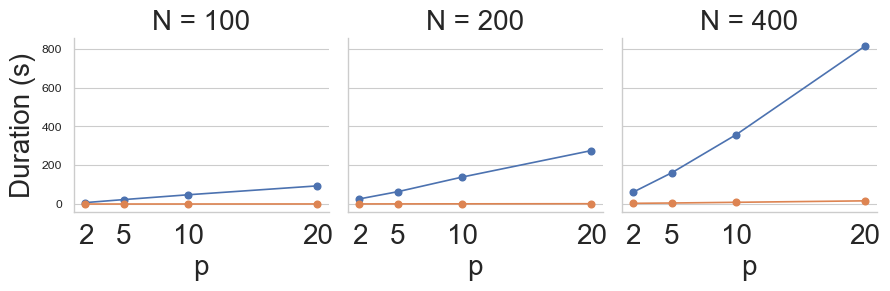

In [4]:
from plot_bench import *
sns.set_theme()

forest_df = make_forest_df(df)
plot_forest_df(forest_df)

 /Users/matthieubulte/Documents/university/phd/merf/benchmark/plot_bench.py:7: FutureWarning:The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


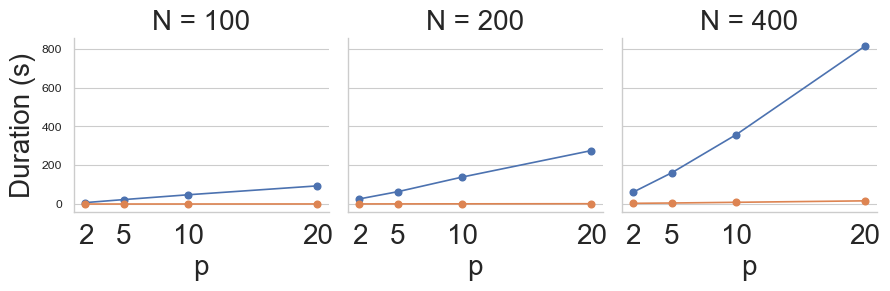

In [5]:
from plot_bench import *
forest_df = make_forest_df(df)
plot_forest_df(forest_df)
plt.savefig("./runtime_phase.pdf")

## MSE CART vs Medoid

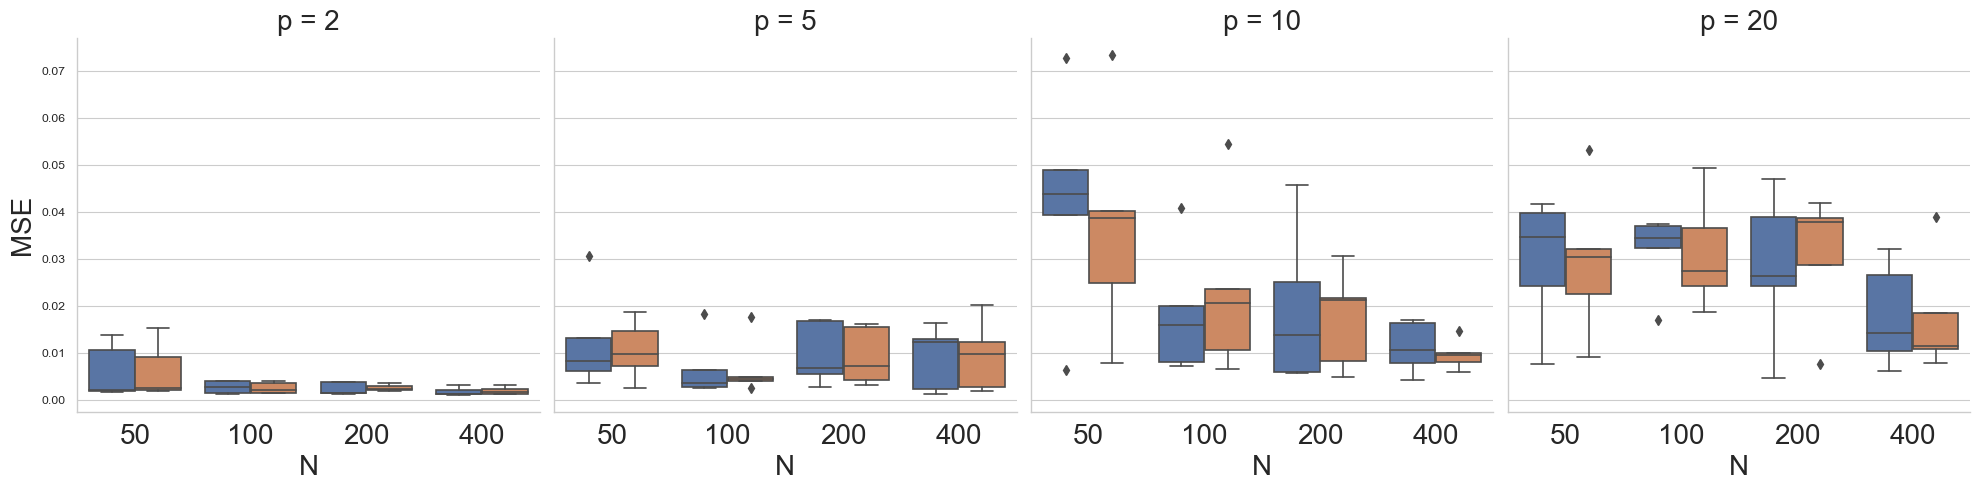

In [6]:
from plot_bench import *
plot_errors(df)
plt.savefig("./error_phase.pdf")

([<matplotlib.patches.Rectangle object at 0x162a43d30>, <matplotlib.patches.Rectangle object at 0x16295a550>], ['RFWLCFR', 'MRF'])


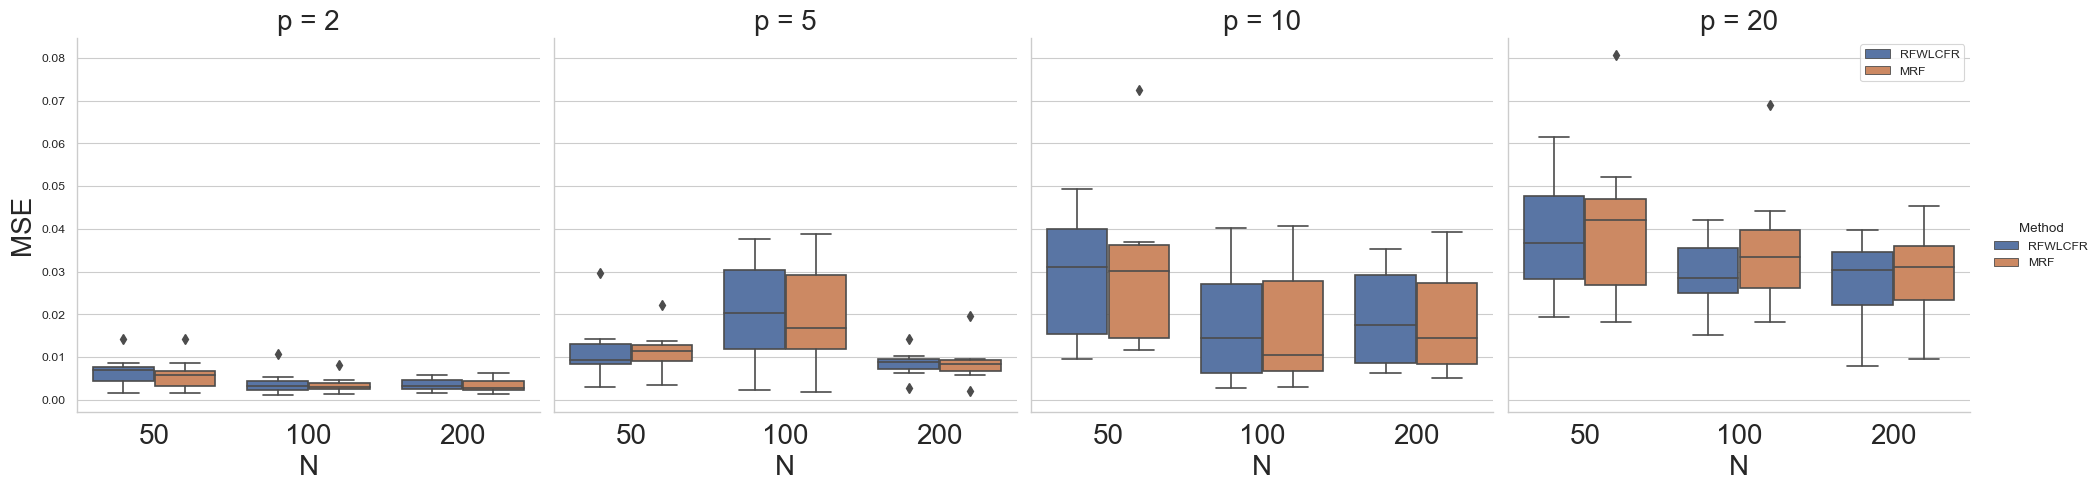

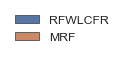

In [128]:
def make_legend(df, expand=[-5,-5,5,5]):
    df = df.copy().rename(columns={ 'err': 'MSE' })
    df['Method'] = df.method.map({'cart_2means': 'RFWLCFR', 'medoid_greedy': 'MRF' })
    sns.set_style("whitegrid")
    sns.set_context("paper", rc={
        "axes.labelsize": 20,
        "xtick.labelsize": 20
    })
    grid = sns.catplot(df,
        x='N', y='MSE',
        col="p",
        hue="Method",
        kind='box')

    legend = plt.legend()
    fig = legend.figure
    fig.canvas.draw()
    bbox = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())

    legend_fig, legend_ax = plt.subplots(figsize=(bbox.width, bbox.height))
    print(grid.axes[0][0].get_legend_handles_labels(),)
    legend_squared = legend_ax.legend(
        *grid.axes[0][0].get_legend_handles_labels(), 
        bbox_to_anchor=(0, 0, 1, 1),
        bbox_transform=legend_fig.transFigure,
        frameon=False,
        fancybox=None,
        shadow=False,
        ncol=1,
        mode='expand',
    )
    legend_ax.axis('off')
    legend_fig.savefig(
        './legend.pdf',
        bbox_inches='tight',
        bbox_extra_artists=[legend_squared],)


make_legend(df)


## Runtime CART vs Medoid

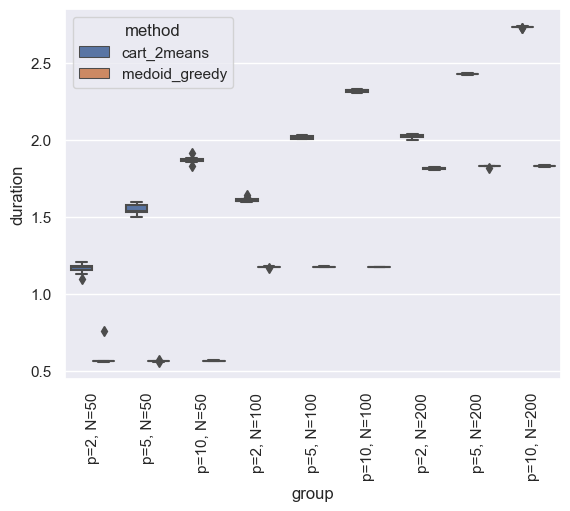

In [8]:
sns.boxplot(df, y=np.log10(df['duration']), x='group', hue='method')
plt.xticks(rotation=90);